In [68]:
import pandas as pd
import numpy as np
import datetime
import time
import os
import matplotlib.pyplot as py
import sys
from cProfile import Profile


In [2]:
# data dictionary
'''
    用户标识（uId）匿名化处理后的用户唯一标识（ID取值从1000001开始，依次递增）----------------------!!! 有序列表
    应用标识（appId）匿名化处理后的app唯一标识
    使用时长（duration）1天内用户对某app的累计使用时长
    打开次数（times）1天内用户对某app的累计打开次数
    使用日期（use_date）用户对某app的使用日期
'''

'\n    用户标识（uId）匿名化处理后的用户唯一标识（ID取值从1000001开始，依次递增）----------------------!!! 有序列表\n    应用标识（appId）匿名化处理后的app唯一标识\n    使用时长（duration）1天内用户对某app的累计使用时长\n    打开次数（times）1天内用户对某app的累计打开次数\n    使用日期（use_date）用户对某app的使用日期\n'

In [73]:
# function blocks:
def dateToInt(minDate='2019-02-01',maxDate='2019-04-30'):
    '''
    for cleaning the datetime-type data
    start from 0 increasingly by 1
    '''
    d = {}
    i = 1
    start = datetime.datetime.strptime(minDate,'%Y-%m-%d')
    end = datetime.datetime.strptime(maxDate,'%Y-%m-%d')
    time = start
    while time <= end:
        d[datetime.datetime.strftime(time,'%Y-%m-%d')]=i
        time = time + datetime.timedelta(1)
        i+=1
#     print(np.array([str(v)+' : '+str(k) for k,v in d.items()],dtype='str').reshape(-1,1)) # meanning of integer
    return d


def mapToInt(ls):
    '''
    for cleaning the uId
    translate the uId to integer
    '''
    d={}
    i=1
    for v in ls:
        if v in d:
            pass
        else:
            d[v]=i
            i+=1
#     print(np.array([str(v)+' : '+str(k) for k,v in d.items()],dtype='str').reshape(-1,1))
    return d


def fileSlice(filepath='./user_app_usage.csv',CHUNK_SIZE = 10000000):
    '''
    for slicing file into many small files, default size of small file is 20*CHUNKSIZE
    output file name is
    '''
    reader = pd.read_csv(filepath, iterator=True, names=['uId','appId','duration','times','use_date'])
    
    EOF = True
    i = 0
    s = 0
    start = time.time()
    count = 0
    while EOF:
        try:
            chunk = reader.get_chunk(CHUNK_SIZE)
            i+=1
            gap = time.time()
            s=s+gap-start
            print(i,' time gap:',gap-start,' all time:',s,chunk.shape)
            start = gap
            chunk.to_csv('{0}_{1}.csv'.format(os.path.splitext(os.path.basename(filepath))[0],i//20+1),header = False, mode='a')

        except:
            EOF = False
            print('end of file')
            print(i*CHUNK_SIZE)

            
def appIdMapToInt(chunk,dic):
    '''
    covert the appId to integer in chunk
    '''
    dic_appId_int = dic #
    def chage(x):
        x[1]=dic_appId_int[x[1]]
        return x
    chunk = chunk.apply(chage,axis=1)
    np.save('dic_appId_int',dic) # save the map of appId and integer to file
    return chunk,'dic_appId_int.npy'


def get_features_from_df(df):
    '''
    uid,
    
    duration, dur_max, dur_min, dur_var, dur_mean, 25%, 50%, 75%
    times,times_max, times_min, times_var, times_mean, 25%, 50%, 75%
    use_date, ud_count, 
    
    appId, app_count, category,
    '''
    # duration and times features
    
    ##
    dt = df.drop('use_date',axis=1)

    df_duration_times=dt.groupby('uId').describe().reset_index(level='uId',col_level=0,drop=False)
    df_duration_times.columns=['uId','duration', 'dur_max', 'dur_min', 'dur_var', 'dur_mean','dur_25%', 'dur_50%', 'dur_75%',\
                                     'times','times_max', 'times_min', 'times_var', 'times_mean', 'times_25%', 'times_50%', 'times_75%']
#     print(df_duration_times)
    
    
    # date featrues
    
    ##
#     df_uId_date = df.drop(['duration','times'],axis=1)
#     df_date_count = df_uId_date.pivot_table(index=['uId','appId'],aggfunc='count')
#     print(df_date_count)
    
    
    #appId features
    
    ##
    df_uId_appId = df.drop(['duration','times','use_date'],axis=1)
    df_app_count = df_uId_appId.groupby('uId').describe().reset_index()
    df_app_count.columns=['uId','app_count_monthly','app_num_in_use_unique','app_top','app_freq']
    ### drop app_count_monthly => all apps in use not unique
    df_app_count.drop('app_count_monthly',axis=1,inplace=True)
    
    
    # app category features
    
    ##
    
    
    # all features
    
    ##
    ft_all = pd.merge(df_app_count,df_duration_times)
#     print(type(ft_all))
    return ft_all
    
    



In [4]:
# data cleaning:

In [89]:
def get_features_from_big_file(filename = './uau_1.csv',chunk_size=10000):
    t_all=0
    start = time.time()
    rdc = pd.read_csv(filename,iterator=True,names=['uId','appId','duration','times','use_date'])
    i=0
    next_chunk_to_be_concat = pd.DataFrame()

    while True:
        try:
            df_c = rdc.get_chunk(chunk_size)
            df_c = pd.concat([next_chunk_to_be_concat,df_c])
            last_value = df_c['uId'][-1:].values[0]
            first_index_of_last_value = list(df_c['uId']).index(last_value)+i*chunk_size
            next_chunk_to_be_concat = df_c[first_index_of_last_value:]
    #         print(df_c,last_value,first_index_of_last_value)
            df_c.drop(list(range(first_index_of_last_value,first_index_of_last_value+len(next_chunk_to_be_concat))),inplace = True)

            # extract features
            # 1001091
            df_features = get_features_from_df(df_c)
            df_features.to_csv('features.csv',mode='a')
            
        except:
            print('Exception or End',str(Exception))
        finally:
            end = time.time()
            t_all = t_all+end-start
            i+=1
            print('Already processed {0} records, time costs {1}'.format(i*chunk_size,t_all))
            df_features.reset_index(drop=True,inplace=True)
            print(df_features)
            
            if i>0:
                break

    
prof = Profile()
prof.runcall(get_features_from_big_file)
prof.print_stats()
# get_features_from_big_file()
# print(t)

<class 'pandas.core.frame.DataFrame'>
Already processed 10000 records, time costs 0.5172379016876221
        uId app_num_in_use_unique    app_top app_freq  duration      dur_max  \
0   1000364                    13  a00289791       30     198.0  1973.515152   
1   1000387                    41  a00287085       30     491.0  1986.160896   
2   1000872                    29   a0036392       30     406.0   861.123153   
3   1000951                    21  a00289850       30     223.0  1677.932735   
4   1001091                   160  a00274909       30    1019.0   871.041217   
5   1001365                    15  a00102782       30     219.0   695.885845   
6   1001441                    56  a00170432       30     672.0  1179.020833   
7   1001627                    21  a00289826       30     248.0  2507.431452   
8   1001700                    40  a00289826       26     468.0  1117.108974   
9   1001710                    38  a00287085       30     388.0  1252.644330   
10  1002654        

        2    0.000    0.000    0.000    0.000 common.py:171(is_gcs_url)
       31    0.000    0.000    0.000    0.000 common.py:175(_all_none)
        2    0.000    0.000    0.000    0.000 common.py:1752(is_complex_dtype)
     1152    0.001    0.000    0.004    0.000 common.py:1784(_is_dtype)
        2    0.000    0.000    0.002    0.001 common.py:179(get_filepath_or_buffer)
     3668    0.002    0.000    0.004    0.000 common.py:1809(_get_dtype)
       56    0.000    0.000    0.000    0.000 common.py:183(_any_not_none)
     9624    0.010    0.000    0.024    0.000 common.py:1845(_is_dtype_type)
       56    0.000    0.000    0.000    0.000 common.py:1892(infer_dtype_from_object)
     4983    0.004    0.000    0.007    0.000 common.py:1981(pandas_dtype)
        5    0.000    0.000    0.000    0.000 common.py:199(count_not_none)
       15    0.000    0.000    0.000    0.000 common.py:201(<genexpr>)
      113    0.000    0.000    0.000    0.000 common.py:212(dict_keys_to_ordered_list)
  

      112    0.000    0.000    0.000    0.000 generic.py:3110(_is_view)
      115    0.000    0.000    0.001    0.000 generic.py:3115(_maybe_update_cacher)
      233    0.000    0.000    0.000    0.000 generic.py:3149(_clear_item_cache)
        5    0.000    0.000    0.002    0.000 generic.py:3155(_slice)
       63    0.000    0.000    0.000    0.000 generic.py:3175(_set_is_copy)
      112    0.000    0.000    0.000    0.000 generic.py:3184(_check_is_chained_assignment_possible)
      115    0.000    0.000    0.000    0.000 generic.py:3205(_check_setitem_copy)
       60    0.001    0.000    0.025    0.000 generic.py:3323(_take)
      146    0.000    0.000    0.000    0.000 generic.py:334(<dictcomp>)
        3    0.000    0.000    0.000    0.000 generic.py:337(_from_axes)
        2    0.000    0.000    0.000    0.000 generic.py:3461(xs)
      580    0.001    0.000    0.001    0.000 generic.py:349(_get_axis_number)
     1281    0.001    0.000    0.002    0.000 generic.py:363(_get_axis_na

        1    0.000    0.000    0.004    0.004 parsers.py:1120(_make_engine)
        1    0.000    0.000    0.014    0.014 parsers.py:1137(read)
        1    0.000    0.000    0.000    0.000 parsers.py:1162(_create_index)
        1    0.000    0.000    0.014    0.014 parsers.py:1166(get_chunk)
        1    0.000    0.000    0.000    0.000 parsers.py:1176(_is_index_col)
        2    0.000    0.000    0.000    0.000 parsers.py:1180(_is_potential_multi_index)
        4    0.000    0.000    0.000    0.000 parsers.py:1195(<genexpr>)
        1    0.000    0.000    0.000    0.000 parsers.py:1274(_validate_usecols_arg)
        1    0.000    0.000    0.000    0.000 parsers.py:1329(_validate_parse_dates_arg)
        1    0.000    0.000    0.000    0.000 parsers.py:1352(__init__)
        2    0.000    0.000    0.000    0.000 parsers.py:1423(_has_complex_date_col)
        1    0.000    0.000    0.000    0.000 parsers.py:1430(_should_parse_dates)
        1    0.000    0.000    0.000    0.000 parsers

In [10]:
# process data to drop columns

rdc = pd.read_csv('./uau_1.csv',iterator=True,names=['uId','appId','duration','times','use_date'])
c = rdc.get_chunk(10000)

# print(c)
return

start = time.time()

cdf = c = rdc.get_chunk(10000000)


i=0
try:
    while True:
        c = rdc.get_chunk(10000000)
        if i==0:
            cdf.drop(['duration','times','use_date'],axis=1,inplace = True)
        else:
            c.drop(['duration','times','use_date'],axis=1,inplace = True)
            cdf = cdf.append(c)
        i+=1
        if i%3==0:
            print(i)
except:
    print('end of file')
finally:
    end = time.time()
    print(cdf,end-start,i)





          uId      appId  duration  times    use_date
0     1000364  a00289850     752.0    2.0  2019-03-01
1     1000364  a00287085     836.0   19.0  2019-03-12
2     1000364  a00289826     166.0   23.0  2019-03-01
3     1000364  a00287085     836.0   19.0  2019-03-13
4     1000364  a00278858     123.0   45.0  2019-03-19
5     1000364  a00289850     731.0    2.0  2019-03-03
6     1000364  a00289791    6758.0  157.0  2019-03-20
7     1000364  a00289850      31.0    4.0  2019-03-29
8     1000364  a00157220      10.0    4.0  2019-03-11
9     1000364  a00290027    1259.0    7.0  2019-03-02
10    1000364  a00278858     228.0   33.0  2019-03-13
11    1000364  a00278858    1767.0   41.0  2019-03-16
12    1000364  a00289826      17.0    1.0  2019-03-14
13    1000364  a00290027     649.0    7.0  2019-03-21
14    1000364  a00278858      81.0   29.0  2019-03-03
15    1000364  a00287085    1398.0   27.0  2019-03-17
16    1000364  a00278858     234.0    4.0  2019-03-28
17    1000364  a00157220    

SyntaxError: 'return' outside function (<ipython-input-10-59e60ea5f46f>, line 8)

In [77]:
### process the date column

rd = pd.read_csv('./uau_1.csv',iterator=True, names=['uId','appId','duration','times','use_date'])
chunk = rd.get_chunk(100000)

dic_date_int = dateToInt(chunk.values[:,4].min(),chunk.values[:,4].max())

start = time.time()

for k,v in dic_date_int.items():
    chunk.replace(k,v,inplace=True) # the reason for use_date replace operation is fast is that the data cluster massively

end = time.time()

print(chunk,end-start)



           uId      appId  duration  times  use_date
0      1000364  a00289850     752.0    2.0         2
1      1000364  a00287085     836.0   19.0        13
2      1000364  a00289826     166.0   23.0         2
3      1000364  a00287085     836.0   19.0        14
4      1000364  a00278858     123.0   45.0        20
5      1000364  a00289850     731.0    2.0         4
6      1000364  a00289791    6758.0  157.0        21
7      1000364  a00289850      31.0    4.0        30
8      1000364  a00157220      10.0    4.0        12
9      1000364  a00290027    1259.0    7.0         3
10     1000364  a00278858     228.0   33.0        14
11     1000364  a00278858    1767.0   41.0        17
12     1000364  a00289826      17.0    1.0        15
13     1000364  a00290027     649.0    7.0        22
14     1000364  a00278858      81.0   29.0         4
15     1000364  a00287085    1398.0   27.0        18
16     1000364  a00278858     234.0    4.0        29
17     1000364  a00157220      20.0    5.0    

In [220]:
# file: app_info


df_app = pd.read_csv('./app_info.csv')
d = dict(zip(df_app.values[:,0],df_app.values[:,1]))
s = pd.unique(df_app.values[:,1])
dic_apptype_int=mapToInt(s)
# print(np.array([str(v)+' : '+str(k) for k,v in dic_apptype_int.items()],dtype='str').reshape(-1,1))

# why a-b != empty ????????
a = set(chunk.values[:,1])
b = set(df_app.values[:,0])
print('the number appId in user_app_usage but not in app_info: ',len(a - b))


# slow: the best choice is cope with it separately

# def extend(r):
#     r['app_type']=dic_apptype_int[d[r['appId']]] if r['appId'] in d else 0
#     return r
# print(chunk.apply(extend,axis=1))



the number appId in user_app_usage but not in app_info:  3880
               uId      appId  duration  times  use_date  app_type
590000000  2345916  a00275200      17.0   10.0        17         1
590000001  2345916  a00287397      22.0    5.0        11        13
590000002  2345916  a00274701   11001.0  368.0        24        18
590000003  2345916  a00289866     678.0   15.0        25         4
590000004  2345916  a00275200    1217.0   19.0        25         1
590000005  2345916  a00311680       3.0    1.0         7        14
590000006  2345916  a00275200     258.0   61.0         1         1
590000007  2345916  a00336224       6.0    4.0        15        14
590000008  2345916  a00289826      52.0    4.0        20        13
590000009  2345916  a00450743     107.0    2.0        19        12
590000010  2345916  a00287397      77.0    9.0        20        13
590000011  2345916  a00289866     678.0   15.0        26         4
590000012  2345916  a00274701    1519.0   89.0        25        18


In [176]:
# process the appId —— convert appId to integer


# start = time.time()
dic_appId_int = mapToInt(chunk.values[:,1])
# chunk=appIdMapToInt(chunk,dic_appId_int)
# end = time.time()
# print(chunk,end-start)

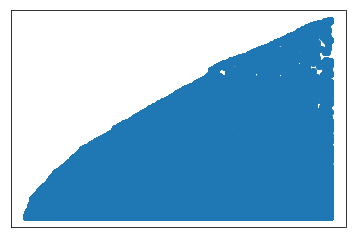

In [180]:
# x: uId, y: appId


py.yticks([])
py.xticks([])
py.scatter(chunk.head(10000000).values[:,0],chunk.head(10000000).values[:,1])

In [11]:
dic_user_int = mapToInt(chunk.values[:,0])
print('number of user: ',len(dic_user_int))
# print('number of app: ',len(dic_appId_int))

# chunk[['appId']] = chunk[['appId']].astype('str')
# chunk.sort_values(by=['uId','appId'],inplace=True)
tmp = chunk.groupby(['uId'])
print(tmp.describe())


number of user:  2987
        duration                                                       \
           count          mean           std    min      25%      50%   
uId                                                                     
1000364    198.0   1973.515152   4600.297805    1.0    61.25    343.0   
1000387    491.0   1986.160896   3338.793126    1.0    85.00    475.0   
1000872    406.0    861.123153   1912.555912    4.0    62.00    171.0   
1000951    223.0   1677.932735   2826.470570    2.0    79.00    335.0   
1001091   1019.0    871.041217   2445.063938    1.0    42.50    128.0   
1001365    219.0    695.885845   1131.097247    3.0    68.50    253.0   
1001441    672.0   1179.020833   3185.850363    1.0    42.00    104.5   
1001627    248.0   2507.431452   4487.527149    3.0    79.50    583.5   
1001700    468.0   1117.108974   1603.310332    1.0    90.25    360.5   
1001710    388.0   1252.644330   2297.541625    2.0    69.00    213.0   
1002654    318.0   2641.60377

In [179]:
# get_features_from_df()





         uId app_num_in_use_unique    app_top app_freq  duration      dur_max  \
0    1000364                    13  a00289791       30     198.0  1973.515152   
1    1000387                    41  a00287085       30     491.0  1986.160896   
2    1000872                    29   a0036392       30     406.0   861.123153   
3    1000951                    21  a00289850       30     223.0  1677.932735   
4    1001091                   160  a00289791       30    1019.0   871.041217   
5    1001365                    15  a00289791       30     219.0   695.885845   
6    1001441                    56  a00287397       30     672.0  1179.020833   
7    1001627                    21  a00292780       30     248.0  2507.431452   
8    1001700                    40  a00289826       26     468.0  1117.108974   
9    1001710                    38  a00287085       30     388.0  1252.644330   
10   1002654                    46   a0048562       30     318.0  2641.603774   
11   1002722                